In [132]:
import pandas as pd
import numpy as np
import re
import spacy
import gensim
import en_core_web_sm
import emoji
import nltk
import matplotlib.pyplot as plt 
import string
import seaborn as sns
from sklearn.metrics import roc_curve
import matplotlib.patches as mpatches

In [108]:
from spacy.tokenizer import Tokenizer
from gensim.parsing.preprocessing import STOPWORDS as SW
from wordcloud import WordCloud
from wordcloud import STOPWORDS
stopwords = set(STOPWORDS)
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from optparse import Values
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [109]:
df = pd.read_csv('cleaned_py.csv')

In [111]:
df

,Unnamed: 0,created_at,lang,author_id,text,id,text_token
0,0,2022-09-09T23:59:41.000Z,en,78429986,The pressure is mounting for asset owners to t...,1568388706762981378,"['pressure', 'mounting', 'asset', 'owners', 't..."
1,1,2022-09-09T23:59:21.000Z,en,1515895379329708032,RT @dvdmckay: We’ve got a new paper out on cli...,1568388623288107008,"['@dvdmckay:', 'we’ve', 'got', 'new', 'paper',..."
2,2,2022-09-09T23:59:16.000Z,en,1547977583714660355,RT @DEATHBALL13: Let's not forget good old #Ch...,1568388601926524928,"['@deathball13:', ""let's"", 'forget', 'good', '..."
3,3,2022-09-09T23:58:51.000Z,en,1302354043793223680,RT @EnergyLiveNews: Prime Minister Liz Truss a...,1568388497152638978,"['@energylivenews:', 'prime', 'minister', 'liz..."
4,4,2022-09-09T23:58:45.000Z,en,126075164,RT @EnergyHouseVA: Energy Crisis Will Be Short...,1568388472695853056,"['@energyhouseva:', 'energy', 'crisis', 'short..."
...,...,...,...,...,...,...,...
95,95,2022-09-09T23:34:30.000Z,en,225901906,RT @UNFPA_Arabic: Supporting women and girls i...,1568382369853480961,"['@unfpa_arabic:', 'supporting', 'women', 'gir..."
96,96,2022-09-09T23:33:46.000Z,en,2544970722,"RT @Trudeaus_Ego: This afternoon, our cabinet ...",1568382183596871682,"['@trudeaus_ego:', 'afternoon,', 'cabinet', 'm..."
97,97,2022-09-09T23:33:44.000Z,qht,1315918007550369792,#ClimateChange #GlobalWarming #ClimateEmergenc...,1568382177133600769,"['#climatechange', '#globalwarming', '#climate..."
98,98,2022-09-09T23:31:52.000Z,qme,1316425828549394436,#ClimateStrike #savetheplanet #savethetrees #c...,1568381704141967360,"['#climatestrike', '#savetheplanet', '#savethe..."


In [112]:
def emoji_remove(text):
    emoji_list = [c for c in text if emoji.is_emoji(c)]
    clean_text = ' '.join([str for str in text.split() if not any(i in str for i in emoji_list)])
    return clean_text

def url_free_text(text):
    '''
    Cleans text from urls
    '''
    text = re.sub(r'http\S+', '', text)
    return text

# Apply the function above and get tweets free of emoji's
call_emoji_free = lambda x: emoji_remove(x)

# Apply `call_emoji_free` which calls the function to remove all emoji's
df['emoji_free_tweets'] = df['text'].apply(call_emoji_free)

#Create a new column with url free tweets
df['url_free_tweets'] = df['emoji_free_tweets'].apply(url_free_text)

In [113]:
# Load spacy
# Make sure to restart the runtime after running installations and libraries tab
nlp = spacy.load('en_core_web_sm')

#nlp = en_core_web_lg.load()
# Tokenizer
tokenizer = Tokenizer(nlp.vocab)


# Custom stopwords
custom_stopwords = ['hi','\n','\n\n', '&amp;', ' ', '.', '-','climatechange','climate','change','got', "it's", 'it’s', "i'm", 'i’m', 'im', '$', '@']

# Customize stop words by adding to the default list
STOP_WORDS = nlp.Defaults.stop_words.union(custom_stopwords)

# ALL_STOP_WORDS = spacy + gensim + wordcloud
ALL_STOP_WORDS = STOP_WORDS.union(SW).union(stopwords)


tokens = []

for doc in tokenizer.pipe(df['url_free_tweets'], batch_size=500):
    doc_tokens = []    
    for token in doc: 
        if token.text.lower() not in STOP_WORDS:
            doc_tokens.append(token.text.lower())   
    tokens.append(doc_tokens)

# Makes tokens column
df['tokens'] = tokens

In [114]:
# Make tokens a string again
df['tokens_back_to_text'] = [' '.join(map(str, l)) for l in df['tokens']]

def get_lemmas(text):
    '''Used to lemmatize the processed tweets'''
    lemmas = []
    
    doc = nlp(text)
    
    # Something goes here :P
    for token in doc: 
        if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_ != 'PRON'):
            lemmas.append(token.lemma_)
    
    return lemmas

df['lemmas'] = df['tokens_back_to_text'].apply(get_lemmas)

In [115]:
# Make lemmas a string again
df['lemmas_back_to_text'] = [' '.join(map(str, l)) for l in df['lemmas']]

# Tokenizer function
def tokenize(text):
    """
    Parses a string into a list of semantic units (words)
    Args:
        text (str): The string that the function will tokenize.
    Returns:
        list: tokens parsed out
    """
    # Removing url's
    pattern = r"http\S+"
    
    tokens = re.sub(pattern, "", text) # https://www.youtube.com/watch?v=O2onA4r5UaY
    tokens = re.sub('[^a-zA-Z 0-9]', '', text)
    tokens = re.sub('[%s]' % re.escape(string.punctuation), '', text) # Remove punctuation
    tokens = re.sub('\w*\d\w*', '', text) # Remove words containing numbers
    tokens = re.sub('@*!*\$*', '', text) # Remove @ ! $
    tokens = tokens.strip(',') # TESTING THIS LINE
    tokens = tokens.strip('?') # TESTING THIS LINE
    tokens = tokens.strip('!') # TESTING THIS LINE
    tokens = tokens.strip("'") # TESTING THIS LINE
    tokens = tokens.strip(".") # TESTING THIS LINE

    tokens = tokens.lower().split() # Make text lowercase and split it
    
    return tokens

# Apply tokenizer
df['lemma_tokens'] = df['lemmas_back_to_text'].apply(tokenize)

In [116]:
#find positive word
with open("positive-words.txt",'r') as f:
    positive_words=[line.strip() for line in f]

negations=['not', 'too', 'n\'t', 'no', 'cannot', 'neither','nor']

text_positive=df['lemma_tokens']

positive_tokens=[]
for idx, l in enumerate(text_positive):
    for token in l:
        if token in positive_words:
            if idx>0:
                if text_positive[idx-1] not in negations:
                    positive_tokens.append(token)
            else:
                positive_tokens.append(token)

In [117]:
with open("negative-words.txt",'r') as f:
    negative_words=[line.strip() for line in f]

negations=['not', 'too', 'n\'t', 'no', 'cannot', 'neither','nor']

text_negative=df['lemma_tokens']

negative_tokens=[]
for idx, l in enumerate(text_negative):
    for token in l:
        if token in negative_words:
            if idx>0:
                if text_negative[idx-1] not in negations:
                    negative_tokens.append(token)
            else:
                negative_tokens.append(token)

In [118]:
# find sentiment tokens combined both negative and positive words
def find_positive_words(target_list):
    return list(set(target_list).intersection(positive_tokens))
def find_negative_words(target_list):
    return list(set(target_list).intersection(negative_tokens))

In [119]:
#create new columns for postive words, negative words and combined with the lemma_tokens
df['positive_sentiment'] = df['lemma_tokens'].apply(find_positive_words)
df['negative_sentiment'] = df['lemma_tokens'].apply(find_negative_words)
df['sentiment_tokens'] = df['positive_sentiment'] + df['negative_sentiment']
df.head()

,Unnamed: 0,created_at,lang,author_id,text,id,text_token,emoji_free_tweets,url_free_tweets,tokens,tokens_back_to_text,lemmas,lemmas_back_to_text,lemma_tokens,positive_sentiment,negative_sentiment,sentiment_tokens
0,0,2022-09-09T23:59:41.000Z,en,78429986,The pressure is mounting for asset owners to t...,1568388706762981378,"['pressure', 'mounting', 'asset', 'owners', 't...",The pressure is mounting for asset owners to t...,The pressure is mounting for asset owners to t...,"[pressure, mounting, asset, owners, tackle, im...",pressure mounting asset owners tackle impacts ...,"[pressure, mount, asset, owner, tackle, impact...",pressure mount asset owner tackle impact clima...,"[pressure, mount, asset, owner, tackle, impact...",[],[],[]
1,1,2022-09-09T23:59:21.000Z,en,1515895379329708032,RT @dvdmckay: We’ve got a new paper out on cli...,1568388623288107008,"['@dvdmckay:', 'we’ve', 'got', 'new', 'paper',...",RT @dvdmckay: We’ve got a new paper out on cli...,RT @dvdmckay: We’ve got a new paper out on cli...,"[rt, @dvdmckay:, we’ve, new, paper, #tippingpo...",rt @dvdmckay: we’ve new paper #tippingpoints @...,"[rt, @dvdmckay, new, paper, tippingpoint, @sci...",rt @dvdmckay new paper tippingpoint @sciencema...,"[rt, dvdmckay, new, paper, tippingpoint, scien...",[exceed],[],[exceed]
2,2,2022-09-09T23:59:16.000Z,en,1547977583714660355,RT @DEATHBALL13: Let's not forget good old #Ch...,1568388601926524928,"['@deathball13:', ""let's"", 'forget', 'good', '...",RT @DEATHBALL13: Let's not forget good old #Ch...,RT @DEATHBALL13: Let's not forget good old #Ch...,"[rt, @deathball13:, let's, forget, good, old, ...",rt @deathball13: let's forget good old #charli...,"[rt, @deathball13, let, forget, good, old, cha...",rt @deathball13 let forget good old charlieche...,"[rt, deathball13, let, forget, good, old, char...",[good],[propaganda],"[good, propaganda]"
3,3,2022-09-09T23:58:51.000Z,en,1302354043793223680,RT @EnergyLiveNews: Prime Minister Liz Truss a...,1568388497152638978,"['@energylivenews:', 'prime', 'minister', 'liz...",RT @EnergyLiveNews: Prime Minister Liz Truss a...,RT @EnergyLiveNews: Prime Minister Liz Truss a...,"[rt, @energylivenews:, prime, minister, liz, t...",rt @energylivenews: prime minister liz truss a...,"[rt, @energylivenews, prime, minister, liz, tr...",rt @energylivenews prime minister liz truss an...,"[rt, energylivenews, prime, minister, liz, tru...",[],[freeze],[freeze]
4,4,2022-09-09T23:58:45.000Z,en,126075164,RT @EnergyHouseVA: Energy Crisis Will Be Short...,1568388472695853056,"['@energyhouseva:', 'energy', 'crisis', 'short...",RT @EnergyHouseVA: Energy Crisis Will Be Short...,RT @EnergyHouseVA: Energy Crisis Will Be Short...,"[rt, @energyhouseva:, energy, crisis, short-li...",rt @energyhouseva: energy crisis short-lived r...,"[rt, @energyhouseva, energy, crisis, short, li...",rt @energyhouseva energy crisis short live rea...,"[rt, energyhouseva, energy, crisis, short, liv...",[],[crisis],[crisis]


In [120]:
df = df[df.astype(str)['sentiment_tokens'] != '[]']

In [121]:
df

,Unnamed: 0,created_at,lang,author_id,text,id,text_token,emoji_free_tweets,url_free_tweets,tokens,tokens_back_to_text,lemmas,lemmas_back_to_text,lemma_tokens,positive_sentiment,negative_sentiment,sentiment_tokens
1,1,2022-09-09T23:59:21.000Z,en,1515895379329708032,RT @dvdmckay: We’ve got a new paper out on cli...,1568388623288107008,"['@dvdmckay:', 'we’ve', 'got', 'new', 'paper',...",RT @dvdmckay: We’ve got a new paper out on cli...,RT @dvdmckay: We’ve got a new paper out on cli...,"[rt, @dvdmckay:, we’ve, new, paper, #tippingpo...",rt @dvdmckay: we’ve new paper #tippingpoints @...,"[rt, @dvdmckay, new, paper, tippingpoint, @sci...",rt @dvdmckay new paper tippingpoint @sciencema...,"[rt, dvdmckay, new, paper, tippingpoint, scien...",[exceed],[],[exceed]
2,2,2022-09-09T23:59:16.000Z,en,1547977583714660355,RT @DEATHBALL13: Let's not forget good old #Ch...,1568388601926524928,"['@deathball13:', ""let's"", 'forget', 'good', '...",RT @DEATHBALL13: Let's not forget good old #Ch...,RT @DEATHBALL13: Let's not forget good old #Ch...,"[rt, @deathball13:, let's, forget, good, old, ...",rt @deathball13: let's forget good old #charli...,"[rt, @deathball13, let, forget, good, old, cha...",rt @deathball13 let forget good old charlieche...,"[rt, deathball13, let, forget, good, old, char...",[good],[propaganda],"[good, propaganda]"
3,3,2022-09-09T23:58:51.000Z,en,1302354043793223680,RT @EnergyLiveNews: Prime Minister Liz Truss a...,1568388497152638978,"['@energylivenews:', 'prime', 'minister', 'liz...",RT @EnergyLiveNews: Prime Minister Liz Truss a...,RT @EnergyLiveNews: Prime Minister Liz Truss a...,"[rt, @energylivenews:, prime, minister, liz, t...",rt @energylivenews: prime minister liz truss a...,"[rt, @energylivenews, prime, minister, liz, tr...",rt @energylivenews prime minister liz truss an...,"[rt, energylivenews, prime, minister, liz, tru...",[],[freeze],[freeze]
4,4,2022-09-09T23:58:45.000Z,en,126075164,RT @EnergyHouseVA: Energy Crisis Will Be Short...,1568388472695853056,"['@energyhouseva:', 'energy', 'crisis', 'short...",RT @EnergyHouseVA: Energy Crisis Will Be Short...,RT @EnergyHouseVA: Energy Crisis Will Be Short...,"[rt, @energyhouseva:, energy, crisis, short-li...",rt @energyhouseva: energy crisis short-lived r...,"[rt, @energyhouseva, energy, crisis, short, li...",rt @energyhouseva energy crisis short live rea...,"[rt, energyhouseva, energy, crisis, short, liv...",[],[crisis],[crisis]
5,5,2022-09-09T23:58:39.000Z,en,80890155,RT @NickKristof: We just lost power here at @K...,1568388444430245888,"['@nickkristof:', 'lost', 'power', '@kristoffa...",RT @NickKristof: We just lost power here at @K...,RT @NickKristof: We just lost power here at @K...,"[rt, @nickkristof:, lost, power, @kristoffarms...",rt @nickkristof: lost power @kristoffarms rura...,"[rt, @nickkristof, lose, power, @kristoffarm, ...",rt @nickkristof lose power @kristoffarm rural ...,"[rt, nickkristof, lose, power, kristoffarm, ru...",[],[lose],[lose]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,93,2022-09-09T23:35:20.000Z,en,3418339671,RT @i_ameztoy: Summer 2022 was warmest on reco...,1568382577924534272,"['@i_ameztoy:', 'summer', '2022', 'warmest', '...",RT @i_ameztoy: Summer 2022 was warmest on reco...,RT @i_ameztoy: Summer 2022 was warmest on reco...,"[rt, @i_ameztoy:, summer, 2022, warmest, recor...",rt @i_ameztoy: summer 2022 warmest record #sva...,"[rt, @i_ameztoy, summer, 2022, warm, record, s...",rt @i_ameztoy summer 2022 warm record svalbard...,"[rt, i_ameztoy, summer, 2022, warm, record, sv...",[warm],[],[warm]
94,94,2022-09-09T23:34:45.000Z,en,2650617704,RT @dvdmckay: We’ve got a new paper out on cli...,1568382433078419457,"['@dvdmckay:', 'we’ve', 'got', 'new', 'paper',...",RT @dvdmckay: We’ve got a new paper out on cli...,RT @dvdmckay: We’ve got a new paper out on cli...,"[rt, @dvdmckay:, we’ve, new, paper, #tippingpo...",rt @dvdmckay: we’ve new paper #tippingpoints @...,"[rt, @dvdmckay, new, paper, tippingpoint, @sci...",rt

In [122]:
#Transfer negative and positive words into numbers
df['len_tokens'] = df['sentiment_tokens'].apply(lambda x : len(x))
df = df.drop(df[df['len_tokens'] == 0].index)
df['has_positive'] = df['positive_sentiment'].apply(lambda x: int(len(x) > 0))
df['has_negative'] = df['negative_sentiment'].apply(lambda x: int(len(x) > 0))
df['label'] =df['has_positive'] - df['has_negative']
df.head()

<ipython-input-122-5196873943ee>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['len_tokens'] = df['sentiment_tokens'].apply(lambda x : len(x))


,Unnamed: 0,created_at,lang,author_id,text,id,text_token,emoji_free_tweets,url_free_tweets,tokens,...,lemmas,lemmas_back_to_text,lemma_tokens,positive_sentiment,negative_sentiment,sentiment_tokens,len_tokens,has_positive,has_negative,label
1,1,2022-09-09T23:59:21.000Z,en,1515895379329708032,RT @dvdmckay: We’ve got a new paper out on cli...,1568388623288107008,"['@dvdmckay:', 'we’ve', 'got', 'new', 'paper',...",RT @dvdmckay: We’ve got a new paper out on cli...,RT @dvdmckay: We’ve got a new paper out on cli...,"[rt, @dvdmckay:, we’ve, new, paper, #tippingpo...",...,"[rt, @dvdmckay, new, paper, tippingpoint, @sci...",rt @dvdmckay new paper tippingpoint @sciencema...,"[rt, dvdmckay, new, paper, tippingpoint, scien...",[exceed],[],[exceed],1,1,0,1
2,2,2022-09-09T23:59:16.000Z,en,1547977583714660355,RT @DEATHBALL13: Let's not forget good old #Ch...,1568388601926524928,"['@deathball13:', ""let's"", 'forget', 'good', '...",RT @DEATHBALL13: Let's not forget good old #Ch...,RT @DEATHBALL13: Let's not forget good old #Ch...,"[rt, @deathball13:, let's, forget, good, old, ...",...,"[rt, @deathball13, let, forget, good, old, cha...",rt @deathball13 let forget good old charlieche...,"[rt, deathball13, let, forget, good, old, char...",[good],[propaganda],"[good, propaganda]",2,1,1,0
3,3,2022-09-09T23:58:51.000Z,en,1302354043793223680,RT @EnergyLiveNews: Prime Minister Liz Truss a...,1568388497152638978,"['@energylivenews:', 'prime', 'minister', 'liz...",RT @EnergyLiveNews: Prime Minister Liz Truss a...,RT @EnergyLiveNews: Prime Minister Liz Truss a...,"[rt, @energylivenews:, prime, minister, liz, t...",...,"[rt, @energylivenews, prime, minister, liz, tr...",rt @energylivenews prime minister liz truss an...,"[rt, energylivenews, prime, minister, liz, tru...",[],[freeze],[freeze],1,0,1,-1
4,4,2022-09-09T23:58:45.000Z,en,126075164,RT @EnergyHouseVA: Energy Crisis Will Be Short...,1568388472695853056,"['@energyhouseva:', 'energy', 'crisis', 'short...",RT @EnergyHouseVA: Energy Crisis Will Be Short...,RT @EnergyHouseVA: Energy Crisis Will Be Short...,"[rt, @energyhouseva:, energy, crisis, short-li...",...,"[rt, @energyhouseva, energy, crisis, short, li...",rt @energyhouseva energy crisis short live rea...,"[rt, energyhouseva, energy, crisis, short, liv...",[],[crisis],[crisis],1,0,1,-1
5,5,2022-09-09T23:58:39.000Z,en,80890155,RT @NickKristof: We just lost power here at @K...,1568388444430245888,"['@nickkristof:', 'lost', 'power', '@kristoffa...",RT @NickKristof: We just lost power here at @K...,RT @NickKristof: We just lost power here at @K...,"[rt, @nickkristof:, lost, power, @kristoffarms...",...,"[rt, @nickkristof, lose, power, @kristoffarm, ...",rt @nickkristof lose power @kristoffarm rural ...,"[rt, nickkristof, lose, power, kristoffarm, ru...",[],[lose],[lose],1,0,1,-1


In [123]:
df.to_csv('nb_py.csv')

In [124]:
#tfidf 
vectorizer = TfidfVectorizer (max_features=2500, min_df=7, max_df=0.8, stop_words='english')
processed_features = vectorizer.fit_transform(df['lemmas_back_to_text']).toarray()
X_train, X_test, y_train, y_test = train_test_split(processed_features, df['label'], test_size=0.2, random_state=0)

In [125]:
# Naive Bayes Classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)
nb_predictions = nb_classifier.predict(X_test)
nb_accuracy = accuracy_score(y_test, nb_predictions)
print(confusion_matrix(y_test,nb_predictions))
print(classification_report(y_test,nb_predictions))
print(accuracy_score(y_test, nb_predictions))

[[6 0 0]
 [2 3 0]
 [2 0 1]]
              precision    recall  f1-score   support

          -1       0.60      1.00      0.75         6
           0       1.00      0.60      0.75         5
           1       1.00      0.33      0.50         3

    accuracy                           0.71        14
   macro avg       0.87      0.64      0.67        14
weighted avg       0.83      0.71      0.70        14

0.7142857142857143


<AxesSubplot:>

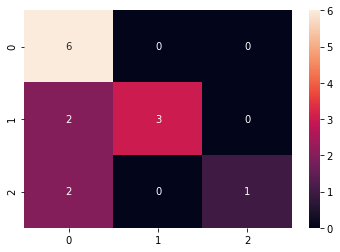

In [126]:
sns.heatmap(confusion_matrix(y_test,nb_predictions), annot=True)

/Users/ritaguan/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/ritaguan/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/ritaguan/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/ritaguan/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/ritaguan/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/ritaguan/opt/anaconda3/lib/python3.8/site-packages/seaborn/dist

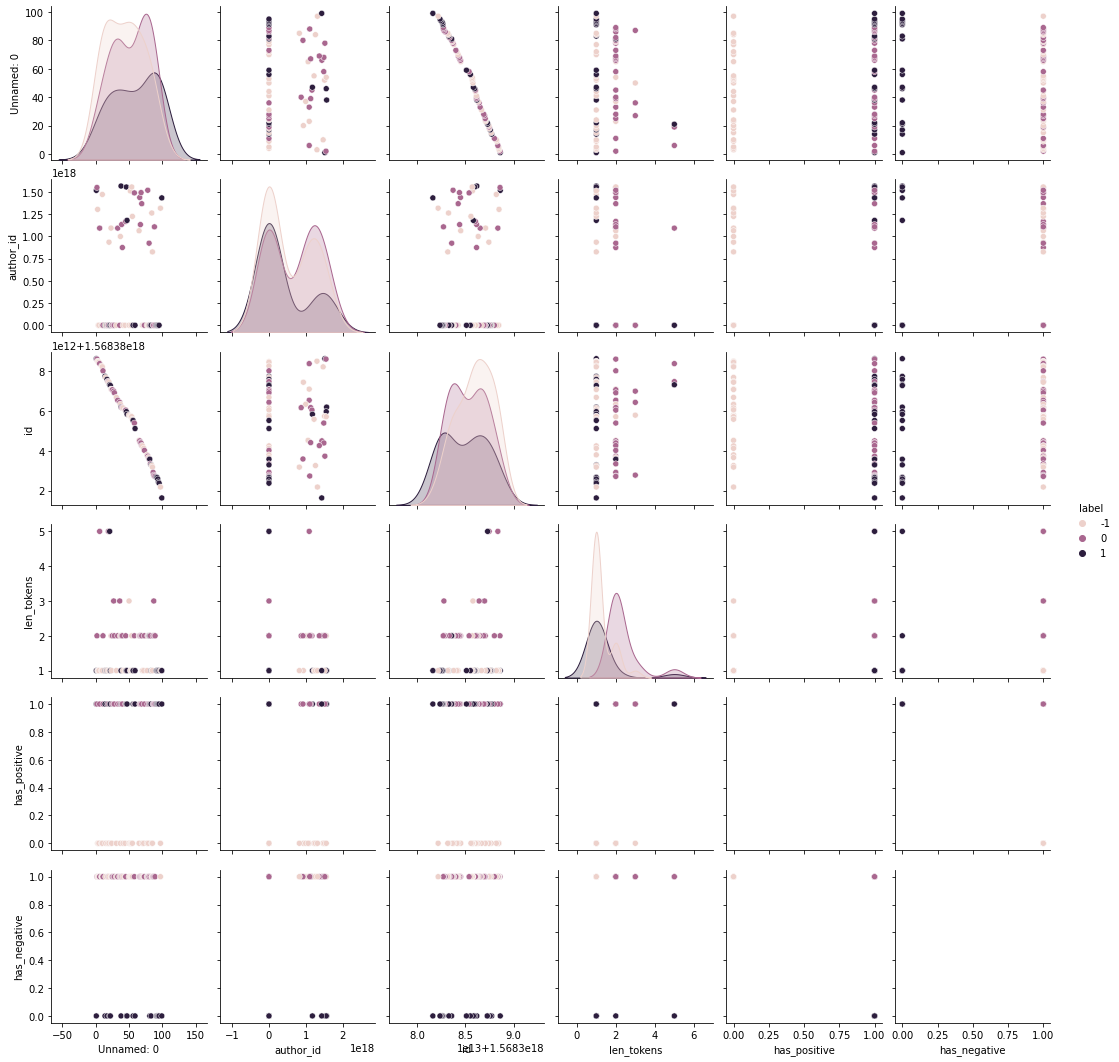

In [81]:
sns.pairplot(df, hue='label')

In [127]:
train_acc = nb_classifier.score(X_train, y_train)
test_acc = nb_classifier.score(X_test, y_test)

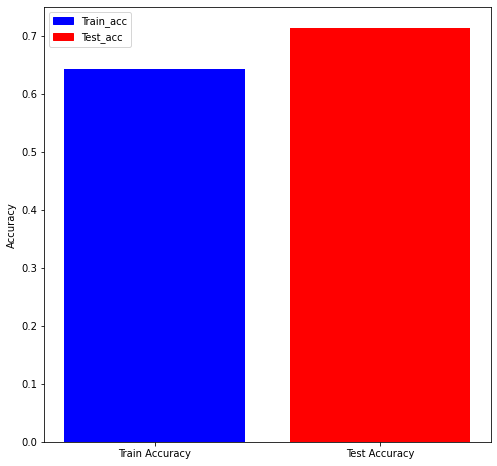

In [136]:
acc = [train_acc, test_acc]
label = ['Train Accuracy', 'Test Accuracy']
plt.ylabel('Accuracy')
plt.xticks(range(len(acc)), label)
plt.bar(range(len(acc)),acc, color=['blue', 'red'])
Train_acc = mpatches.Patch(color='blue', label='Train_acc')
Test_acc = mpatches.Patch(color='red', label='Test_acc')
plt.legend(handles=[Train_acc, Test_acc],loc='best')
plt.gcf().set_size_inches(8, 8)
plt.show()